<a href="https://colab.research.google.com/github/qhfks27/PyTorch/blob/master/RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN

RNN : 데이터가 순서대로 나열된 순차적 데이터(sequential data) 혹은 시계열 데이터(time series data)의 정보를 받아 전체 내용을 학습하는 신경망    
## 영화 리뷰 감정 분석 (텍스트 감정 분석)
   

- IMDB : 인터넷 영화 데이터 베이스. 텍스트 형태의 데이터셋   

영화 리뷰 텍스트를 RNN에 입력해 영화평 전체 내용을 압축하고 이 압축된 리뷰가 긍정적인지 부정적인지 판단해주는 간단한 분류 모델을 만드는 것이 목표이다. 

긍정적인 영화 리뷰는 2, 부정적인 영화는 1로 레이블링.

In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets       #자연어 데이터셋을 다루므로 토치비전이 아닌 토치텍스트 사용
from torchsummary import summary

In [0]:
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 20
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", DEVICE)

다음 기기로 학습합니다: cuda


In [0]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True)    
LABEL = data.Field(sequential=False, batch_first=True)
#sequential 파라미터를 이용해 테이터셋이 순차적인 데이터임을 명시
#batch_first 파라미터로 신경망에 입력되는 텐서의 첫번째 차원값이 batch_size가 되도록 정함.             
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)
TEXT.build_vocab(trainset, min_freq=5)
LABEL.build_vocab(trainset)

데이터 로딩중...


In [0]:
#IMDB 데이터셋에선 따로 검증셋이 존재하지않아 학습 진행도 확인을 위한 검증셋이 부족해 데이터셋을 쪼개어 사용.
trainset, valset = trainset.split(split_ratio=0.8)   
#trainset, valset, testset에서 반복할 때마다 배치를 생성해주는 반복자 형성.
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)

#사전 속 단어들의 개수와 레이블의 수를 정해준느 변수를 만듦.
vocab_size = len(TEXT.vocab)
n_classes = 2


print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
      % (len(trainset),len(valset), len(testset), vocab_size, n_classes))

[학습셋]: 20000 [검증셋]: 5000 [테스트셋]: 25000 [단어수]: 46159 [클래스] 2


##LSTM과 GRU
-LSTM(Long Short-Term Memory) : 은닉층의 메모리 셀에 입력 게이트, 삭제 게이트, 출력 게이트를 추가하여 불필요한 기억을 지우고 기억해야할 것들을 정하는 RNN   
-GRU(Gated Recurrent Unit) : 업데이트 게이트와 리셋 게이트 두가지 게이트만 존재. LSTM보다 학습 속도가 빠르다고 알려져있지만 GRU와 LSTM은 비슷한 성능을 보인다고 알려져있음. GRU는 학습 도중 기울기가 폭발적으로 커지거나 작아지는 현상을 막기위해 개발한 형태.

In [0]:
class LSTM(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(LSTM, self).__init__()
        print("Building LSTM model...")
        self.n_layers = n_layers
        self.embed = nn.Embedding(n_vocab, embed_dim)      #총 단어의 개수, 임베딩된 단어 텐서가 지니는 텐서값
        self.hidden_dim = hidden_dim                       #은닉벡터의 차원값 정의
        self.dropout = nn.Dropout(dropout_p)               #드롭아웃 설정
        self.lstm = nn.LSTM(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)                                  #임베딩을 통해 영화평들을 벡터의 배열, 시계열 데이터로 변환
        h_0 = self._init_state(batch_size=x.size(0))       #첫번째 은닉벡터 정의
        c_0 = self._init_state(batch_size=x.size(0))       #cell state 정의
        x, _ = self.lstm(x, (h_0, c_0))  # [i, b, h]
        h_t = x[:,-1,:]
        self.dropout(h_t)
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data             #가중치 텐서 추출
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()   #첫번째 은닉벡터를 모든 특성값이 0인 벡터가 되도록 설정

In [0]:
class BasicGRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        print("Building Basic GRU model...")
        self.n_layers = n_layers
        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0))
        x, _ = self.gru(x, h_0)  # [i, b, h]
        h_t = x[:,-1,:]
        self.dropout(h_t)
        logit = self.out(h_t)  # [b, h] -> [b, o]
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [0]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):   #반복마다 배치 데이터 반환
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()  #기울기 0으로 초기화

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()


def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy


In [0]:
model = LSTM(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Building LSTM model...


In [0]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[이폭: %d] 검증 오차:%5.2f | 검증 정확도:%5.2f" % (e, val_loss, val_accuracy))
    
    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[이폭: 1] 검증 오차: 0.69 | 검증 정확도:49.80
[이폭: 2] 검증 오차: 0.69 | 검증 정확도:50.24
[이폭: 3] 검증 오차: 0.70 | 검증 정확도:49.64
[이폭: 4] 검증 오차: 0.70 | 검증 정확도:49.56
[이폭: 5] 검증 오차: 0.72 | 검증 정확도:51.02
[이폭: 6] 검증 오차: 0.72 | 검증 정확도:50.36
[이폭: 7] 검증 오차: 0.74 | 검증 정확도:53.18
[이폭: 8] 검증 오차: 0.72 | 검증 정확도:51.44
[이폭: 9] 검증 오차: 0.73 | 검증 정확도:51.48
[이폭: 10] 검증 오차: 0.75 | 검증 정확도:51.96
[이폭: 11] 검증 오차: 0.74 | 검증 정확도:53.18
[이폭: 12] 검증 오차: 0.73 | 검증 정확도:56.92
[이폭: 13] 검증 오차: 0.58 | 검증 정확도:73.62
[이폭: 14] 검증 오차: 0.71 | 검증 정확도:50.54
[이폭: 15] 검증 오차: 0.71 | 검증 정확도:52.98
[이폭: 16] 검증 오차: 0.70 | 검증 정확도:58.24
[이폭: 17] 검증 오차: 0.58 | 검증 정확도:73.62
[이폭: 18] 검증 오차: 0.50 | 검증 정확도:78.16
[이폭: 19] 검증 오차: 0.43 | 검증 정확도:83.28
[이폭: 20] 검증 오차: 0.45 | 검증 정확도:84.16


In [0]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.49 | 테스트 정확도: 80.98


In [0]:
print(model)

LSTM(
  (embed): Embedding(46159, 128)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(128, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=2, bias=True)
)


In [0]:
def count_parameters(model):

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
count = count_parameters(model)
print(count)

6304130


##Seq2Seq 기계번역
영어 알파벳 문자열("hello")를 스페인어 알파벳 문자열("hola")로 번역하는 비니 Seq2Seq 모델 구현

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

In [2]:
vocab_size = 256  # 총 아스키 코드 개수
x_ = list(map(ord, "hello"))  # 아스키 코드 리스트로 변환
y_ = list(map(ord, "hola"))   # 아스키 코드 리스트로 변환
print("hello -> ", x_)
print("hola  -> ", y_)

hello ->  [104, 101, 108, 108, 111]
hola  ->  [104, 111, 108, 97]


In [0]:
x = torch.LongTensor(x_)
y = torch.LongTensor(y_)

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.n_layers = 1
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.encoder = nn.GRU(hidden_size, hidden_size)
        self.decoder = nn.GRU(hidden_size, hidden_size)
        self.project = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs, targets):
        # 인코더에 들어갈 입력
        initial_state = self._init_state()
        embedding = self.embedding(inputs).unsqueeze(1)
        # embedding = [seq_len, batch_size, embedding_size]
        
        # 인코더 (Encoder)
        encoder_output, encoder_state = self.encoder(embedding, initial_state)
        # encoder_output = [seq_len, batch_size, hidden_size]
        # encoder_state  = [n_layers, seq_len, hidden_size]

        # 디코더에 들어갈 입력
        decoder_state = encoder_state
        decoder_input = torch.LongTensor([0])
        
        # 디코더 (Decoder)
        outputs = []
        
        for i in range(targets.size()[0]):
            decoder_input = self.embedding(decoder_input).unsqueeze(1)
            decoder_output, decoder_state = self.decoder(decoder_input, decoder_state)
            projection = self.project(decoder_output)
            outputs.append(projection)
            
            #티처 포싱(Teacher Forcing) 사용
            decoder_input = torch.LongTensor([targets[i]])

        outputs = torch.stack(outputs).squeeze()
        return outputs
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_size).zero_()

In [0]:
seq2seq = Seq2Seq(vocab_size, 16)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-3)


 반복:0 오차: 5.588308334350586
['Ý', 'à', 'à', '¹']

 반복:100 오차: 2.3219153881073
['h', 'o', 'l', 'a']

 반복:200 오차: 0.571672797203064
['h', 'o', 'l', 'a']

 반복:300 오차: 0.24141940474510193
['h', 'o', 'l', 'a']

 반복:400 오차: 0.14347510039806366
['h', 'o', 'l', 'a']

 반복:500 오차: 0.09880569577217102
['h', 'o', 'l', 'a']

 반복:600 오차: 0.07352884858846664
['h', 'o', 'l', 'a']

 반복:700 오차: 0.05742623656988144
['h', 'o', 'l', 'a']

 반복:800 오차: 0.046365875750780106
['h', 'o', 'l', 'a']

 반복:900 오차: 0.038359031081199646
['h', 'o', 'l', 'a']


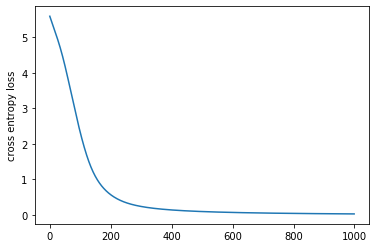

In [6]:
log = []
for i in range(1000):
    prediction = seq2seq(x, y)
    loss = criterion(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_val = loss.data
    log.append(loss_val)
    if i % 100 == 0:
        print("\n 반복:%d 오차: %s" % (i, loss_val.item()))
        _, top1 = prediction.data.topk(1, 1)
        print([chr(c) for c in top1.squeeze().numpy().tolist()])


plt.plot(log)
plt.ylabel('cross entropy loss')
plt.show()
